<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/iidaliisa/FINAL_anger_NN_BoW_testill%C3%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import sklearn.svm
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import os
import pickle

!wget -nc -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -nc -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv

File ‘anger-train.tsv’ already there; not retrieving.
File ‘anger-dev.tsv’ already there; not retrieving.


In [50]:
with open("anger-train.tsv", "r") as f:
  anger_train = pd.read_csv(("anger-train.tsv"), header=0, names=['annotation','text'], sep='\t') # luetaan .tsv-tiedosto ja tallennetaan sen anger_trainiin, käyttäen pandas-kirjastoa

# Datan katsomista varten:
# print(anger_train[:10])
# print(type(anger_train))

with open("anger-dev.tsv", "r") as f:
  anger_dev = pd.read_csv(("anger-dev.tsv"), header=0, names=['annotation','text'], sep='\t') # sama dev-teksteille

# Seuraavaksi luetaan tekstit ja niiden annotationit omiin listoihinsa molempien (train ja dev) osalta.

train_texts = []
for i in anger_train["text"]:
  train_texts.append(i)
train_labels = []
for i in anger_train["annotation"]:
  train_labels.append(i)

dev_texts = []
for i in anger_dev["text"]:
  dev_texts.append(i)
dev_labels = []
for i in anger_dev["annotation"]:
  dev_labels.append(i)

# sanity check

assert len(train_texts) == len(train_labels)
assert len(dev_texts) == len(dev_labels)

# Listojen sisällön katsomista varten:
#for label, text in list(zip(train_labels, train_texts))[:20]:
  #print(label,text)
#for label, text in list(zip(dev_labels, dev_texts))[:20]:
  #print(label,text)

In [51]:
# Tarkastellaan, mikä osuus datasta on kumpaakin labelia
not_angers = train_labels.count("not-anger")
angers = len(train_labels)-not_angers
percent_anger = (angers/len(train_labels))*100
percent_not = 100-percent_anger

print(f"Not-anger: {not_angers}, {percent_not:.2f}% \nAnger: {angers}, {percent_anger:.2f}%")

Not-anger: 854, 79.96% 
Anger: 214, 20.04%


In [52]:
vectorizer=TfidfVectorizer(binary=True)

# Tehdään sekä train- että dev-teksteistä omat feature matrixit käyttäen tätä vectorizeria (featureiden ollessa nyt siis käytännössä sanoja).
# Train-teksteihin käytetään fit_transformia, jonka avulla vectorizer oppii sanaston ja idf:t ja palauttaa document-term matriisin.
# Koska train-tekstien avulla on tehty jo fit eli opetus, deviin riittää pelkkä transform (joka palauttaa document-term matriisin)

feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)

# keras ei hyväksy numpy-matriiseja, joten ne pitää muuttaa tensor-matriiseiksi luentoesimerkin tapaan.

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

feature_matrix_train_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_train)
feature_matrix_dev_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_dev)

In [54]:
# Muutetaan labelit numeroiksi label_encoderin avulla. Ensin train labeleihin fit_transform joka sovittaa labelit numeoriksi ja palauttaa muutetut.
# Dev-labeleille ei tarvitse taas fittiä enää tehdä, vaan transform riittää.

label_encoder=LabelEncoder() 
class_numbers_train=label_encoder.fit_transform(train_labels)
class_numbers_dev=label_encoder.transform(dev_labels)

In [55]:
example_count,feature_count=feature_matrix_train.shape
example_count2=class_numbers_train.shape[0]
assert example_count==example_count2  # sanity check

class_count=len(label_encoder.classes_) # luokkien määrä, tässä vois olla kaksi, mutta näin voidaan käyttää samaa koodia helpommin muuallakin

# rakennetaan neuraaliverkko:

inp=Input(shape=(feature_count,)) # Input layer
hidden=Dense(150,activation="tanh")(inp) # Hidden layer
outp=Dense(class_count,activation="softmax")(hidden) # Output layer
model=Model(inputs=[inp], outputs=[outp])

model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

hist=model.fit(feature_matrix_train_tf,class_numbers_train,\
               validation_data=(feature_matrix_dev_tf,class_numbers_dev),\
               batch_size=100,verbose=1,epochs=10)

Epoch 1/10
11/11 [==============================] - 1s 27ms/step - loss: 0.6690 - accuracy: 0.7110 - val_loss: 0.5749 - val_accuracy: 0.7949
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.5244 - accuracy: 0.8024 - val_loss: 0.4881 - val_accuracy: 0.7949
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.3994 - accuracy: 0.8208 - val_loss: 0.4475 - val_accuracy: 0.7949
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.3405 - accuracy: 0.8045 - val_loss: 0.4325 - val_accuracy: 0.7949
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.2986 - accuracy: 0.8020 - val_loss: 0.4209 - val_accuracy: 0.8205
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.2281 - accuracy: 0.8961 - val_loss: 0.4118 - val_accuracy: 0.8397
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.1775 - accuracy: 0.9573 - val_loss: 0.4116 - val_accuracy: 0.8590
Epoch 8/10
11

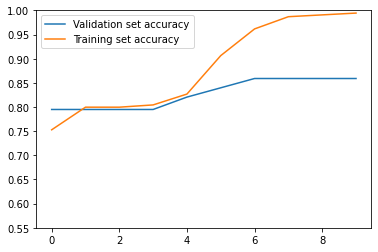

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylim(0.55,1.0)
plt.plot(hist.history["val_accuracy"],label="Validation set accuracy")
plt.plot(hist.history["accuracy"],label="Training set accuracy")
plt.legend()
plt.show()

**Testaus**

In [57]:
!wget -nc -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv

File ‘anger-test.tsv’ already there; not retrieving.


In [61]:
with open("anger-test.tsv", "r") as f:
  anger_test = pd.read_csv(("anger-test.tsv"), header=0, names=['annotation','text'], sep='\t')

test_texts = []
for i in anger_test["text"]:
  test_texts.append(i)
test_labels = []
for i in anger_test["annotation"]:
  test_labels.append(i)

not_angers = test_labels.count("not-anger")
angers = len(test_labels)-not_angers
percent_anger = (angers/len(test_labels))*100
percent_not = 100-percent_anger

print(f"Not-anger: {not_angers}, {percent_not:.2f}% \nAnger: {angers}, {percent_anger:.2f}%\n")

assert len(test_texts) == len(test_labels)
feature_matrix_test=vectorizer.transform(test_texts)
feature_matrix_test_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_test)
class_numbers_test=label_encoder.transform(test_labels)
model.evaluate(feature_matrix_test_tf,class_numbers_test)


Not-anger: 251, 79.68% 
Anger: 64, 20.32%

10/10 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.8571


[0.35557830333709717, 0.8571428656578064]